## Classify candlestick patterns

All patterns in https://thepatternsite.com/Candles2.html will be detected and classified into bullish/ bearish. Assume taking long/short positions at t=0candle accordingly with suitable stop loss/gain, calculate the profit earned at t=5, 10, 15, 20candles. Each candle represent a 1h or 4hr interval. 

In [1]:
import time
# import warnings
from datetime import datetime, timezone
from typing import List, Union
import requests
import pandas as pd
from price_data import BinanceAPI 
from matplotlib import pyplot as plt

bn = BinanceAPI()

Fetch data

In [2]:
btc_4h = pd.read_csv('./csv_files/btc_4h.csv', header=0).set_index('date_time')
eth_4h = pd.read_csv('./csv_files/eth_4h.csv', header=0).set_index('date_time')
# btc_4h = bn.get_kline(symbol = 'BTCUSDT', interval = '4h', instrument_type='spot',start_date = '2022-01-01 00:00:00', end_date='2023-12-31 23:59:59')
# btc_4h[['open', 'high', 'low', 'close', 'volume']
#        ] = btc_4h[['open', 'high', 'low', 'close', 'volume']].astype(float)

# eth_4h = bn.get_kline(symbol = 'ETHUSDT', interval = '4h', instrument_type='spot',start_date = '2022-01-01 00:00:00', end_date='2023-12-31 23:59:59')
# eth_4h[['open', 'high', 'low', 'close', 'volume']
#        ] = eth_4h[['open', 'high', 'low', 'close', 'volume']].astype(float)
# data_4h = [btc_4h, eth_4h]

# btc_4h.to_csv('./csv_files/btc_4h.csv')
# eth_4h.to_csv('./csv_files/eth_4h.csv')

In [23]:
btc_4h.dtypes

open_time                       float64
open                            float64
high                            float64
low                             float64
close                           float64
volume                          float64
close_time                        int64
quote_asset_volume              float64
number_of_trades                  int64
taker_buy_base_asset_volume     float64
taker_buy_quote_asset_volume    float64
ignore                            int64
dtype: object

Variable and mapping set up

In [45]:
metadata = pd.DataFrame([]) #columns=['symbol_interval', 'gain_loss_ratio', 'pattern', 'exposure','mean', 'Q0', 'Q1', 'Q2', 'Q3', 'Q4','skew', 'kurt']
coin_sym_to_dict = {'BTCUSDT_4h': btc_4h, 'ETHUSDT_4h': eth_4h}
coin_sym_data= None

In [46]:
def compute_ret_profit(signal, stop_loss,stop_gain, start_cand:int, exposure:int):
  open_price = coin_sym_data['open'].iloc[start_cand]
  exit_price = None
  
  if signal == 'bull':  # long position
    for cand in range(start_cand, start_cand+exposure):
      if coin_sym_data['low'].iloc[cand] <= stop_loss:
        exit_price = stop_loss
      elif coin_sym_data['high'].iloc[cand] >= stop_gain:
        exit_price = stop_gain
    exit_price = coin_sym_data['close'].iloc[start_cand+exposure-1]
    profit = exit_price - open_price
    return  profit/open_price
  
  elif signal == 'bear': # short position
    for cand in range(start_cand, start_cand+exposure):
      if coin_sym_data['high'].iloc[cand] >= stop_loss:
        exit_price = stop_loss
      elif coin_sym_data['low'].iloc[cand] <= stop_gain:
        exit_price = stop_gain
    exit_price = coin_sym_data['close'].iloc[start_cand+exposure-1]
    profit = open_price - exit_price
    return profit/open_price
  
  return None, None

In [47]:
def above_the_stomach(i, gain_loss_ratio) -> Union[dict, None]:
  conditions = [
                coin_sym_data['open'].iloc[i-5] > coin_sym_data['close'].iloc[i-5],
                coin_sym_data['open'].iloc[i-4] > coin_sym_data['close'].iloc[i-4],
                coin_sym_data['open'].iloc[i-3] > coin_sym_data['close'].iloc[i-3],
                coin_sym_data['open'].iloc[i-2] > coin_sym_data['close'].iloc[i-2],
                coin_sym_data['open'].iloc[i-1] < coin_sym_data['close'].iloc[i-1],
                coin_sym_data['open'].iloc[i] >= (coin_sym_data['open'].iloc[i-2] + coin_sym_data['close'].iloc[i-2])/2]
  if not all(conditions): 
    return None, None, None
  print(i)
  stop_loss = coin_sym_data['low'].iloc[i-2] * .9995
  stop_gain = (coin_sym_data['close'].iloc[i-1] - stop_loss) * \
      gain_loss_ratio + coin_sym_data['close'].iloc[i-1]
  return 'bull', stop_loss, stop_gain


def below_the_stomach(i, gain_loss_ratio) -> Union[dict, None]:
  conditions = [coin_sym_data['open'].iloc[i-5] < coin_sym_data['close'].iloc[i-5],
                coin_sym_data['open'].iloc[i-4] < coin_sym_data['close'].iloc[i-4],
                coin_sym_data['open'].iloc[i-3] < coin_sym_data['close'].iloc[i-3],
                coin_sym_data['open'].iloc[i-2] < coin_sym_data['close'].iloc[i-2],
                coin_sym_data['open'].iloc[i-1] > coin_sym_data['close'].iloc[i-1],
                coin_sym_data['open'].iloc[i] <= (coin_sym_data['open'].iloc[i-2] + coin_sym_data['close'].iloc[i-2])/2]
  if not all(conditions):
    return None, None, None
  # print(i)
  stop_loss = coin_sym_data['high'].iloc[i-2] * 1.0005
  stop_gain = coin_sym_data['close'].iloc[i-1]- (stop_loss - coin_sym_data['close'].iloc[i-1] ) * gain_loss_ratio 
  return 'bear', stop_loss, stop_gain

# def dark_cloud_cover(i, gain_loss_ratio)

In [53]:
patterns_lib = {'above_the_stomach': above_the_stomach, 'below_the_stomach': below_the_stomach}

In [58]:
def detect_pattern_compute_stat(symbol_interval: str, pattern: str, exposure:int, gain_loss_ratio = 3)-> pd.DataFrame:

  df = []
  for i in range(5, len(coin_sym_data.index)-exposure):
    signal, stop_loss, stop_gain = patterns_lib[pattern](i, gain_loss_ratio=gain_loss_ratio)
    # print(i)
    if signal == None:
      continue 
    ret=  compute_ret_profit(signal=signal, stop_loss=stop_loss,
                                      stop_gain=stop_gain, start_cand=i, exposure=exposure)
    df.append({'time': coin_sym_data.index[i], 'signal': signal,'ret': ret})
  # display(df)
  df = pd.DataFrame(df).set_index('time')

  quantiles = list(df['ret'].quantile([0,.25, .5, .75, 1]))
  skew = df['ret'].skew()
  kurt = df['ret'].kurt()
  # display(df.describe())

  fig, graph = plt.subplots()
  graph.hist(df['ret'].sort_values(ignore_index=True), bins=int(len(df.index)*2/3))
  plt.ylabel('Frequency')
  plt.title(f'{symbol_interval}_gainlossratio={gain_loss_ratio}_pattern={pattern}_exposure={exposure}')
  plt.xlabel(f'q0-4={[ round(q, 5) for q in quantiles]}\nskew={skew:.5f}_kurt={kurt:5f}')
  plt.savefig(f"./imagelib/{symbol_interval}_gain_loss_ratio={gain_loss_ratio}_pattern={pattern}_exposure={exposure}.png")
  # display(graph)
  return pd.DataFrame([{'symbol_interval': symbol_interval,
                      'gain_loss_ratio': gain_loss_ratio,
                        'pattern': pattern,
                        'exposure': exposure,
                        'count':len(df.index),
                        'mean': df['ret'].mean(),
                        'Q0': quantiles[0],
                        'Q1': quantiles[1],
                        'Q2': quantiles[2],
                        'Q3': quantiles[3],
                        'Q4': quantiles[4],
                        'skew': skew,
                        'kurt': kurt}])

255
305
381
412
427
535
624
697
775
789
914
986
993
1014
1035
1189
1374
1387
1430
1441
1476
1496
1542
1569
1595
1649
1688
1729
1799
1879
1904
1981
2127
2193
2602
2636
2742
2831
2857
2906
2958
3095
3333
3491
3522
3539
3574
3707
3936
3984
4030
4110
4257
4293
4309
4350
4372
4393
4398
4432
4454
4513
4667
4682
4701
4742
4751
4824
4874
4911
4931
4937


[{'time': '2022-02-12 12:00:00',
  'signal': 'bull',
  'ret': -0.11524182153293552},
 {'time': '2022-02-20 20:00:00', 'signal': 'bull', 'ret': 0.13821833976522252},
 {'time': '2022-03-05 12:00:00',
  'signal': 'bull',
  'ret': -0.012383726071171724},
 {'time': '2022-03-10 16:00:00', 'signal': 'bull', 'ret': 0.05514994429491916},
 {'time': '2022-03-13 04:00:00', 'signal': 'bull', 'ret': 0.07347718672748206},
 {'time': '2022-03-31 04:00:00',
  'signal': 'bull',
  'ret': -0.09151246773845939},
 {'time': '2022-04-15 00:00:00',
  'signal': 'bull',
  'ret': -0.012323755450665677},
 {'time': '2022-04-27 04:00:00',
  'signal': 'bull',
  'ret': -0.06600810522447673},
 {'time': '2022-05-10 04:00:00',
  'signal': 'bull',
  'ret': -0.015257215864867658},
 {'time': '2022-05-12 12:00:00', 'signal': 'bull', 'ret': 0.05003129282568951},
 {'time': '2022-06-02 08:00:00',
  'signal': 'bull',
  'ret': -0.07749463015382606},
 {'time': '2022-06-14 08:00:00',
  'signal': 'bull',
  'ret': -0.08583972388615546

79
132
289
295
315
327
393
473
542
624
697
750
775
789
879
914
967
1156
1242
1296
1430
1609
1646
1667
1729
1774
1877
1904
2040
2091
2154
2166
2224
2359
2391
2424
2432
2577
2586
2602
2665
2764
2779
2831
2955
3035
3095
3147
3378
3566
3579
3642
3665
3714
3723
3744
3758
3794
3883
3900
4019
4176
4229
4293
4372
4382
4465
4484
4500
4513
4564
4585
4606
4813
4824
4837
4874
4937


[{'time': '2022-01-14 04:00:00', 'signal': 'bull', 'ret': -0.2469791178748664},
 {'time': '2022-01-23 00:00:00', 'signal': 'bull', 'ret': 0.1554817633841588},
 {'time': '2022-02-18 04:00:00',
  'signal': 'bull',
  'ret': -0.10293363968754614},
 {'time': '2022-02-19 04:00:00', 'signal': 'bull', 'ret': 0.03794494863440953},
 {'time': '2022-02-22 12:00:00',
  'signal': 'bull',
  'ret': 0.059880123892574834},
 {'time': '2022-02-24 12:00:00', 'signal': 'bull', 'ret': 0.08926214857257414},
 {'time': '2022-03-07 12:00:00', 'signal': 'bull', 'ret': 0.09337535703732895},
 {'time': '2022-03-20 20:00:00', 'signal': 'bull', 'ret': 0.1806168932781584},
 {'time': '2022-04-01 08:00:00',
  'signal': 'bull',
  'ret': -0.03073723627115845},
 {'time': '2022-04-15 00:00:00',
  'signal': 'bull',
  'ret': -0.03341517812824705},
 {'time': '2022-04-27 04:00:00',
  'signal': 'bull',
  'ret': -0.05883389921340903},
 {'time': '2022-05-06 00:00:00',
  'signal': 'bull',
  'ret': -0.21931541943841978},
 {'time': '2

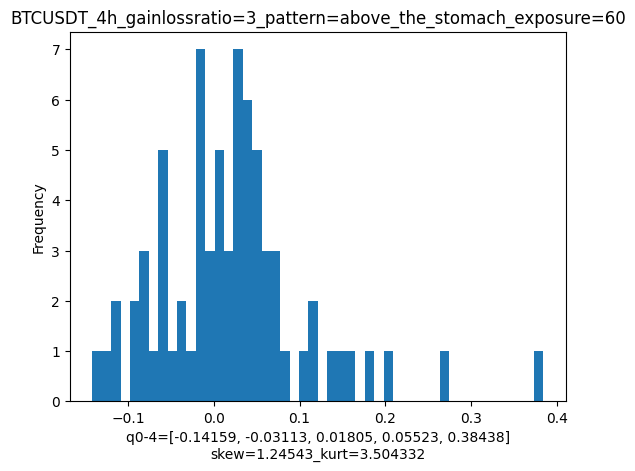

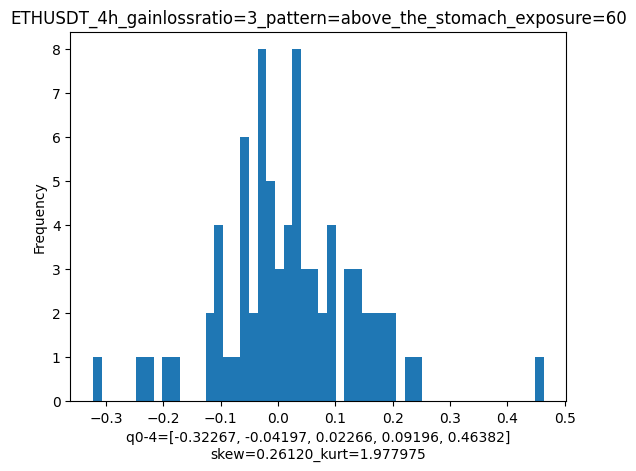

In [62]:
# global coin_sym_data
for this_coin_sym in ['BTCUSDT_4h','ETHUSDT_4h']:
  coin_sym_data = coin_sym_to_dict[this_coin_sym]
  for pattern in ['below_the_stomach','above_the_stomach']:
    for exposure in [60]:
      metadata_row=detect_pattern_compute_stat(
          symbol_interval=this_coin_sym, pattern=pattern, exposure=exposure, gain_loss_ratio=3)
      metadata = pd.concat([metadata, metadata_row])

In [63]:
metadata

,symbol_interval,gain_loss_ratio,pattern,exposure,count,mean,Q0,Q1,Q2,Q3,Q4,skew,kurt
0,BTCUSDT_4h,3,above_the_stomach,1,74,-0.000308,-0.044334,-0.005434,-0.000670,0.005716,0.045264,-0.098731,3.458514
0,BTCUSDT_4h,3,above_the_stomach,2,74,-0.000975,-0.042270,-0.005989,-0.000402,0.006004,0.044367,-0.222643,2.149768
0,BTCUSDT_4h,3,above_the_stomach,6,74,0.001850,-0.094180,-0.006740,0.000401,0.014408,0.084509,-0.073542,3.283877
0,BTCUSDT_4h,3,above_the_stomach,18,74,0.010651,-0.094359,-0.010738,0.003935,0.027630,0.198789,1.057393,4.007085
0,ETHUSDT_4h,3,above_the_stomach,1,79,-0.000937,-0.077568,-0.005478,-0.000709,0.004274,0.032140,-1.658494,8.999523
0,ETHUSDT_4h,3,above_the_stomach,2,79,-0.001010,-0.056102,-0.010479,-0.002579,0.008531,0.084272,0.726955,3.616790
0,ETHUSDT_4h,3,above_the_stomach,6,79,0.003886,-0.121380,-0.014601,0.001631,0.014344,0.128782,0.423201,2.645604
0,ETHUSDT_4h,3,above_the_stomach,18,79,0.001684,-0.296790,-0.024772,-0.004722,0.030043,0.193316,-0.192340,4.074591
0,BTCUSDT_4h,3,below_the_stomach,1,89,-0.001052,-0.084820,-0.004962,-0.000535,0.002343,0.047028,-1.887203,18.918287
0,BTCUSDT_4h,3,below_the_stomach,2,89,-0.003522,-0.098309,-0.006782,-0.002186,0.002730,0.054291,-1.147225,7.720741


In [61]:
# this_coin_sym = 'BTCUSDT'
# pattern = 'above_the_stomach'
# exposure = 18

# detect_pattern_compute_stat(
#     symbol_interval=this_coin_sym, pattern=pattern, exposure=exposure, gain_loss_ratio=3)